In [86]:
%matplotlib inline
from SALib.sample import saltelli
from SALib.analyze import sobol as sobol_analyze
from mesa.batchrunner import batch_run
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output
import pickle
from joblib import Parallel, delayed
from SALib.sample import sobol
from IPython.display import clear_output
import numpy as np
from itertools import product
import time

from model import SugarscapeG1mt

### Sensitivity Analysis - Problem

In [97]:
problem = { 
    "num_vars": 15,
    "names": [
        "initial_population",
        "endowment_min",
        "endowment_max",
        "vision_min",
        "vision_max",
        "metabolism_min",
        "metabolism_max",
        "wealth_tax_system",
        "flat_rate",
        "wealth_tax_period",
        "income_tax_system",
        "income_tax_flat_rate",
        "p_copy",
        "p_mutate",
        "enable_staghunt"
    ],
    "bounds": [
        [50,   500],    # initial_population
        [0,    10],    # endowment_min
        [15,   30],    # endowment_max
        [1.0,     5.0],    # vision_min
        [5.0,     10.0],    # vision_max
        [0.1,  2.0],    # metabolism_min
        [2,     3.9],    # metabolism_max
        [0,     3],     # wealth_tax_system
        [0.0,   0.10],  # flat_rate
        [1,     50],    # wealth_tax_period
        [0,     3],     # income_tax_system
        [0.0,   0.20],  # income_tax_flat_rate
        [0.0,   1.0],   # p_copy
        [0.0,   0.20],  # p_mutate
        [0,     1]      # enable_staghunt
    ]
}

model_reporters = {
    "Gini": lambda m:m.datacollector.get_model_vars_dataframe()['Gini'].iloc[-1],
    "Avg Wealth": lambda m:m.datacollector.get_model_vars_dataframe()['Average Wealth'].iloc[-1],

}

wealth_tax_map = {
    0: "none",  # No wealth tax
    1: "proportional",  # Proportional
    2: "progressive",  # Progressive tax
    3: "degressive"   # Regressive tax
}

income_tax_map = {
    0: "none",  # No income tax
    1: "proportional",  # Proportional income tax
    2: "progressive",  # Progressive income tax
    3: "degressive"   # Regressive income tax
}

integer_vars = {
    "initial_population",
    "endowment_min",
    "endowment_max",
    "vision_min",
    "vision_max",
    "metabolism_min",
    "metabolism_max",
    "wealth_tax_period",
    "wealth_tax_system",
    "income_tax_system",
    "enable_staghunt"
}

discrete_factors = {
    "wealth_tax_system": [0, 1, 2, 3],
    "income_tax_system": [0, 1, 2, 3],
    "enable_staghunt":   [0, 1],
}
# Build reduced Sobol problem for the other 12 vars
cont_vars   = [n for n in problem["names"] if n not in discrete_factors]
cont_bounds = [
    b for (n, b) in zip(problem["names"], problem["bounds"])
         if n not in discrete_factors
]
reduced_problem = {
    "num_vars": len(cont_vars),
    "names":    cont_vars,
    "bounds":   cont_bounds
}

In [112]:
problem = { 
    "num_vars": 10,
    "names": [
        "initial_population",
        "endowment_min",
        "endowment_max",
        "vision_min",
        "vision_max",
        "metabolism_min",
        "metabolism_max",
        "wealth_tax_system",
        "income_tax_system",
        "enable_staghunt"
    ],
    "bounds": [
        [50,   500],    # initial_population
        [5,    10],    # endowment_min
        [15,   30],    # endowment_max
        [1.0,     5.0],    # vision_min
        [5.0,     10.0],    # vision_max
        [0.1,  2.0],    # metabolism_min
        [2,     3.9],    # metabolism_max
        [0,     3],     # wealth_tax_system
        [0,     3],     # income_tax_system
        [0,     1]      # enable_staghunt
    ]
}
problem_staghunt = { 
    "num_vars": 12,
    "names": [
        "initial_population",
        "endowment_min",
        "endowment_max",
        "vision_min",
        "vision_max",
        "metabolism_min",
        "metabolism_max",
        "wealth_tax_system",
        "income_tax_system",
        "p_copy",
        "p_mutate",
        "enable_staghunt"
    ],
    "bounds": [
        [50,   500],    # initial_population
        [1,    10],    # endowment_min
        [15,   30],    # endowment_max
        [1.0,     5.0],    # vision_min
        [5.0,     10.0],    # vision_max
        [0.1,  2.0],    # metabolism_min
        [2,     3.9],    # metabolism_max
        [0,     3],     # wealth_tax_system
        [0,     3],     # income_tax_system
        [0.0,   1.0],   # p_copy
        [0.0,   0.20],  # p_mutate
        [0,     1]      # enable_staghunt
    ]
}

model_reporters = {
    "Gini": lambda m:m.datacollector.get_model_vars_dataframe()['Gini'].iloc[-1],
    "Avg Wealth": lambda m:m.datacollector.get_model_vars_dataframe()['Average Wealth'].iloc[-1],

}

wealth_tax_map = {
    0: "none",  # No wealth tax
    1: "proportional",  # Proportional
    2: "progressive",  # Progressive tax
    3: "degressive"   # Regressive tax
}

income_tax_map = {
    0: "none",  # No income tax
    1: "proportional",  # Proportional income tax
    2: "progressive",  # Progressive income tax
    3: "degressive"   # Regressive income tax
}

integer_vars = {
    "initial_population",
    "endowment_min",
    "endowment_max",
    "vision_min",
    "vision_max",
    "metabolism_min",
    "metabolism_max",
    "wealth_tax_period",
    "wealth_tax_system",
    "income_tax_system",
    "enable_staghunt"
}


integer_vars_staghunt = {
    "initial_population",
    "endowment_min",
    "endowment_max",
    "vision_min",
    "vision_max",
    "metabolism_min",
    "metabolism_max",
    "wealth_tax_period",
    "wealth_tax_system",
    "income_tax_system",
    "p_copy",
    "p_mutate",
    "enable_staghunt"
}


discrete_factors = {
    "wealth_tax_system": [0, 1, 2, 3],
    "income_tax_system": [0, 1, 2, 3],
    "enable_staghunt":   [0, 1],
}
# Build reduced Sobol problem for the other 12 vars
cont_vars   = [n for n in problem["names"] if n not in discrete_factors]
cont_bounds = [
    b for (n, b) in zip(problem["names"], problem["bounds"])
         if n not in discrete_factors
]
reduced_problem = {
    "num_vars": len(cont_vars),
    "names":    cont_vars,
    "bounds":   cont_bounds
}


cont_vars_staghunt = [n for n in problem_staghunt["names"] if n not in discrete_factors]
cont_bounds_staghunt = [
    b for (n, b) in zip(problem_staghunt["names"], problem_staghunt["bounds"])
         if n not in discrete_factors
]
reduced_problem_staghunt = {
    "num_vars": len(cont_vars_staghunt),
    "names":    cont_vars_staghunt,
    "bounds":   cont_bounds_staghunt
}

In [88]:

# --- 2) OFAT (one-factor-at-a-time) sweep ---
replicates   = 2
max_steps    = 10
distinct_OAT = 2

test_vars = ["initial_population", "flat_rate"]

OAT_results = {}
# for i, var in enumerate(problem["names"]):
for var in test_vars:
    i = problem["names"].index(var)
    low, high = problem["bounds"][i]

    # 5a) Categorical parameters: use the map values
    if var == "wealth_tax_regime":
        samples = list(wealth_tax_map.values())
    elif var == "income_tax_system":
        samples = list(income_tax_map.values())

    # 5b) Integer parameters: linspace with dtype=int
    elif var in integer_vars:
        samples = np.linspace(low, high, distinct_OAT, dtype=int)

    # 5c) All other continuous parameters
    else:
        samples = np.linspace(low, high, distinct_OAT)

    # 6) Run the batch
    results = batch_run(
        SugarscapeG1mt,
        parameters={var: samples},
        iterations=replicates,
        max_steps=max_steps,
        data_collection_period=1,
        display_progress=True
    )

    # 7) Collect into a DataFrame
    df = pd.DataFrame(results)
    # print(df.columns.tolist())    # ← inspect the real column names
    # print(df.head())       
    # keep only the columns we care about:
    #   - the varied var
    #   - the run number
    #   - the final reporter ("Gini")
    OAT_results[var] = df[[var, "RunId", "Gini"]]
for var, df in OAT_results.items():
    print(f"\n=== {var} ===")
    print(df)

  0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\imaan\OneDrive\Documenten\CS UVA\Agent Based Modeling\PROJECT\ABM\model.py:25: RuntimeWarning: Mean of empty slice.
  return np.exp(np.log(list_of_prices).mean())
c:\Users\imaan\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Index(['#Traders', 'Trade Volume', 'Price', 'Treasury Sugar', 'Treasury Spice',
       'Treasury Total', 'redistributed cummulative', 'trading', 'Gini',
       'Lorenz', 'Average Wealth'],
      dtype='object')
Index(['#Traders', 'Trade Volume', 'Price', 'Treasury Sugar', 'Treasury Spice',
       'Treasury Total', 'redistributed cummulative', 'trading', 'Gini',
       'Lorenz', 'Average Wealth'],
      dtype='object')
Index(['#Traders', 'Trade Volume', 'Price', 'Treasury Sugar', 'Treasury Spice',
       'Treasury Total', 'redistributed cummulative', 'trading', 'Gini',
       'Lorenz', 'Average Wealth'],
      dtype='object')
Index(['#Traders', 'Trade Volume', 'Price', 'Treasury Sugar', 'Treasury Spice',
       'Treasury Total', 'redistributed cummulative', 'trading', 'Gini',
       'Lorenz', 'Average Wealth'],
      dtype='object')


  0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\imaan\OneDrive\Documenten\CS UVA\Agent Based Modeling\PROJECT\ABM\model.py:25: RuntimeWarning: Mean of empty slice.
  return np.exp(np.log(list_of_prices).mean())
c:\Users\imaan\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Index(['#Traders', 'Trade Volume', 'Price', 'Treasury Sugar', 'Treasury Spice',
       'Treasury Total', 'redistributed cummulative', 'trading', 'Gini',
       'Lorenz', 'Average Wealth'],
      dtype='object')
Index(['#Traders', 'Trade Volume', 'Price', 'Treasury Sugar', 'Treasury Spice',
       'Treasury Total', 'redistributed cummulative', 'trading', 'Gini',
       'Lorenz', 'Average Wealth'],
      dtype='object')
Index(['#Traders', 'Trade Volume', 'Price', 'Treasury Sugar', 'Treasury Spice',
       'Treasury Total', 'redistributed cummulative', 'trading', 'Gini',
       'Lorenz', 'Average Wealth'],
      dtype='object')
Index(['#Traders', 'Trade Volume', 'Price', 'Treasury Sugar', 'Treasury Spice',
       'Treasury Total', 'redistributed cummulative', 'trading', 'Gini',
       'Lorenz', 'Average Wealth'],
      dtype='object')

=== initial_population ===
       initial_population  RunId      Gini
0                      50      0  0.083899
1                      50      0  0.083899

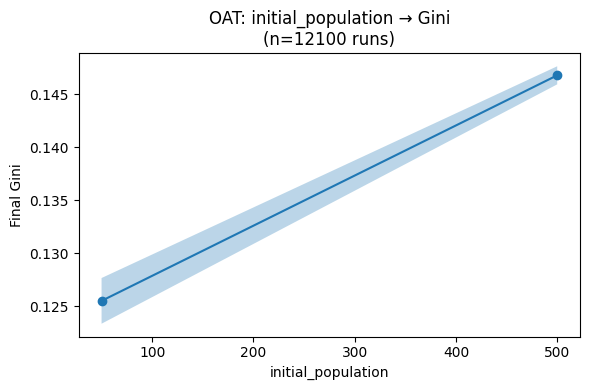

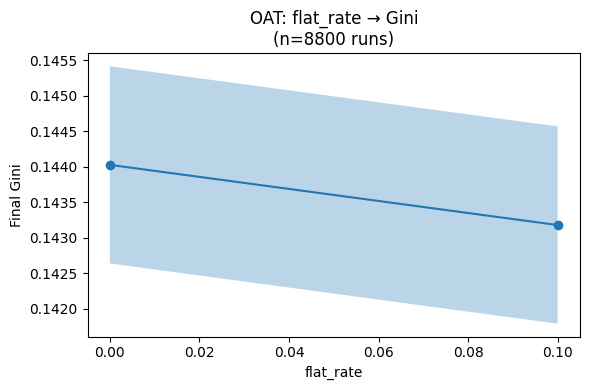

In [89]:
for var in ["initial_population", "flat_rate"]:
    df = OAT_results[var]   # this DF has columns [var, "Gini"]

    # Group by the parameter value
    grp = df.groupby(var)["Gini"]
    x    = grp.mean().index.astype(float)
    y    = grp.mean().values
    sem  = grp.sem().values
    ci   = 1.96 * sem    # 95% interval

    plt.figure(figsize=(6,4))
    plt.plot(x, y, marker="o")
    plt.fill_between(x, y - ci, y + ci, alpha=0.3)
    plt.xlabel(var)
    plt.ylabel("Final Gini")
    plt.title(f"OAT: {var} → Gini\n(n={len(df)} runs)")
    plt.tight_layout()
    plt.show()

### Global Sensitivity Analysis - Sobol (Parallel)

In [90]:
measure = "Gini" # "Gini" # or "Avg Wealth"
second_order = True  # or: "True"Oh

# --- 3) Sobol GSA ---
replicates = 2
max_steps = 10
distinct_SA = 2

In [122]:

param_values = sobol.sample(problem, distinct_SA, calc_second_order=second_order)
total_runs = replicates * len(param_values)
print(f"Total runs for Sobol GSA: {total_runs}")

# --- Helper function to run a single model execution ---
def run_single_sim(run_id, vals):
    vals = list(vals)
    params = {}
    for name, val in zip(problem["names"], vals):
        if name in integer_vars:
            params[name] = int(round(val))
        elif name == "wealth_tax_system":
            params[name] = wealth_tax_map[int(round(val))]
        elif name == "income_tax_system":
            params[name] = income_tax_map[int(round(val))]
        else:
            params[name] = float(val)

    for low_key, high_key in [
        ("endowment_min", "endowment_max"),
        ("vision_min", "vision_max"),
        ("metabolism_min", "metabolism_max"),
    ]:
        lo = params[low_key]
        hi = params[high_key]
        lo, hi = int(min(lo, hi)), int(max(lo, hi))
        params[low_key], params[high_key] = lo, hi

    params["enable_staghunt"] = bool(params["enable_staghunt"])
    out = batch_run(
        SugarscapeG1mt,
        parameters=params,
        iterations=1,
        max_steps=max_steps,
        data_collection_period=-1,
        display_progress=False
    )[0]

    return {
        **params,
        "RunId": run_id,
        "Gini": out["Gini"],
        "Avg Wealth": out["Average Wealth"] }

# --- Create tasks ---
tasks = [(run_id, vals) for run_id in range(replicates) for vals in param_values]

# --- Run in parallel ---
results = Parallel(n_jobs=-1, verbose=10)(delayed(run_single_sim)(run_id, vals) for run_id, vals in tasks)

# --- Done ---
records = results
print(f"Completed all {total_runs} runs.")

# --- 5) Save results ---
output_path = "sobol_gsa_results.pkl"
with open(output_path, "wb") as f:
    pickle.dump(results, f)

print(f"\n All {total_runs} runs completed and saved to '{output_path}'.")


Total runs for Sobol GSA: 88


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  74 out of  88 | elapsed:   26.2s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  83 out of  88 | elapsed:   32.5s remaining:    1.9s


Completed all 88 runs.

 All 88 runs completed and saved to 'sobol_gsa_results.pkl'.


[Parallel(n_jobs=-1)]: Done  88 out of  88 | elapsed:   32.8s finished


c:\Users\imaan\AppData\Local\Programs\Python\Python313\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


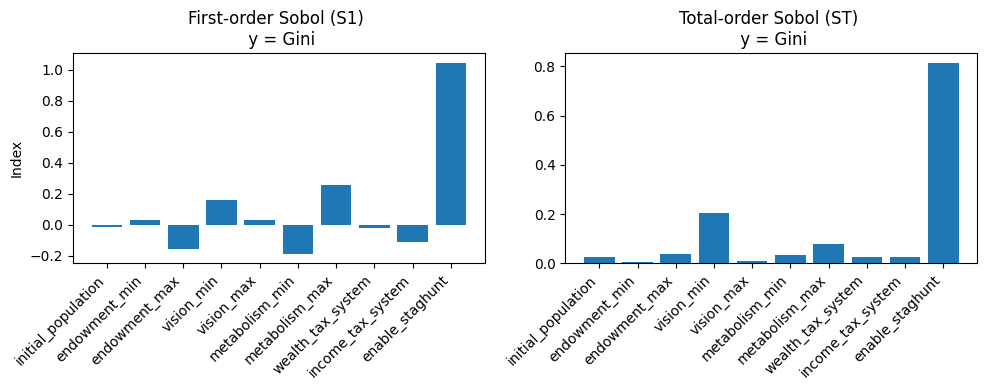

In [123]:
# 7) Build the DataFrame and extract Y
with open("sobol_gsa_results.pkl", "rb") as f:
    records = pickle.load(f)
df = pd.DataFrame(records)
Y  = df[str(measure)].values

# 8) Perform Sobol analysis
Si = sobol_analyze.analyze(
    problem,
    Y,
    calc_second_order=second_order,
    print_to_console=False
)

fig, axes = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

# First‐order
axes[0].bar(problem["names"], Si["S1"])
axes[0].set_title(f"First‐order Sobol (S1) \n y = {measure}")
axes[0].set_ylabel("Index")
# rotate labels
axes[0].tick_params(axis="x", labelrotation=45)
# right‐align tick labels
for lbl in axes[0].get_xticklabels():
    lbl.set_ha("right")

# Total‐order
axes[1].bar(problem["names"], Si["ST"])
axes[1].set_title(f"Total‐order Sobol (ST) \n y = {measure}")
axes[1].tick_params(axis="x", labelrotation=45)
for lbl in axes[1].get_xticklabels():
    lbl.set_ha("right")

plt.show()

### Global SA with Discrete settings for tax systems and stag hunt

In [125]:
def run_mixed(run_id, params):
    # cast ints/floats just as before
    for name in integer_vars:
        if name in params:
            params[name] = int(round(params[name]))
    #params["flat_rate"]           = float(params["flat_rate"])
    #params["income_tax_flat_rate"]= float(params["income_tax_flat_rate"])
    #params["p_copy"]              = float(params["p_copy"])
    #params["p_mutate"]            = float(params["p_mutate"])
    # ensure min≤max
    for low, high in [("endowment_min","endowment_max"),
                        ("vision_min",   "vision_max"),
                        ("metabolism_min","metabolism_max")]:
        lo, hi = sorted((params[low], params[high]))
        params[low], params[high] = int(lo), int(hi)
    # map tax‐system integers to names
    params["wealth_tax_system"] = wealth_tax_map[params["wealth_tax_system"]]
    params["income_tax_system"]= income_tax_map[params["income_tax_system"]]
    # run your model
    out = batch_run(
        SugarscapeG1mt,
        parameters=params,
        iterations=1,
        max_steps=max_steps,
        data_collection_period=-1,
        display_progress=False
    )[0]
    return {
        **params,
        "RunId":    run_id,
        "Gini":     out["Gini"],
        "Avg Wealth": out["Average Wealth"]
    }

In [126]:
import time, multiprocessing
from itertools import product
# Midpoint for continuous vars:
dummy_cont = {
    n: (low + high) / 2
    for n, (low, high) in zip(reduced_problem["names"], reduced_problem["bounds"])
}

# First discrete‐factor setting:
first_wsys = discrete_factors["wealth_tax_system"][0]
first_isys = discrete_factors["income_tax_system"][0]
first_hunt = discrete_factors["enable_staghunt"][0]

dummy_params = {
    **dummy_cont,
    "wealth_tax_system": first_wsys,
    "income_tax_system": first_isys,
    "enable_staghunt":   bool(first_hunt)
}

# 1b) Time a single run:
t0 = time.perf_counter()
_ = run_mixed(0, dummy_params)
t_single = time.perf_counter() - t0
print(f"One run took {t_single:.3f} s")

# 1c) Compute total_runs the same way your loop will:
D = len(reduced_problem["names"])         # number of continuous vars (12)
N = distinct_SA                           # your Sobol base sample
reps = replicates                         # your replicates
n_disc = (len(discrete_factors["wealth_tax_system"])
        * len(discrete_factors["income_tax_system"])
        * len(discrete_factors["enable_staghunt"]))  # = 32

runs_per_slice = reps * N * (D + 2)
total_runs = runs_per_slice * n_disc

# 1d) Estimate wall‐time on your machine
C = multiprocessing.cpu_count()
est_minutes = (total_runs * t_single / C) / 60
print(f"Estimated total runs: {total_runs:,}")
print(f"With {C} cores, wall‐time ≈ {est_minutes:.1f} minutes")

c:\Users\imaan\OneDrive\Documenten\CS UVA\Agent Based Modeling\PROJECT\ABM\model.py:25: RuntimeWarning: Mean of empty slice.
  return np.exp(np.log(list_of_prices).mean())
c:\Users\imaan\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Index(['#Traders', 'Trade Volume', 'Price', 'Treasury Sugar', 'Treasury Spice',
       'Treasury Total', 'redistributed cummulative', 'trading', 'Gini',
       'Lorenz', 'Average Wealth'],
      dtype='object')
One run took 0.806 s
Estimated total runs: 1,152
With 12 cores, wall‐time ≈ 1.3 minutes


# Run for all tax systems, stag hunt disabled

In [134]:
all_records = []
import random
import numpy as np

def run_mixed_safe(run_id, params):
    seed = 1 + run_id
    random.seed(seed)
    np.random.seed(seed)
    try:
        return run_mixed(run_id, params)
    except Exception as e:
        import traceback
        print(traceback.format_exc())
        raise e


for w_sys in  discrete_factors["wealth_tax_system"]: 
    print("running for ", w_sys)
    # 2a) sample continuous part
    cont_samples = sobol.sample(
        reduced_problem,
        N=distinct_SA,
        calc_second_order=second_order
    )

    # 2b) build tasks
    tasks = []
    for run_id, cont_vals in enumerate(cont_samples):
        # merge into a single params dict
        full_params = {n: v for n, v in zip(cont_vars, cont_vals)}
        full_params.update({
            "wealth_tax_system": w_sys,
            "income_tax_system": w_sys,
            "enable_staghunt":   False
        })
        tasks.append((run_id, full_params))
    slice_results = Parallel(n_jobs=-1, verbose=10)(
        delayed(run_mixed_safe)(rid, p) for rid, p in tasks
    )

    record = {
        "discrete_setting": (w_sys, w_sys, False),
        "samples":          cont_samples,
        "results":          slice_results
    }
    all_records.append(record)

    # Save this slice to a separate file
    output_path = f"sobol_gsa_setting_w{w_sys}_hunt0.pkl"
    with open(output_path, "wb") as f:
        pickle.dump(record, f)
    print(f"Saved setting (w_sys={w_sys}, hunt_flag=0) to '{output_path}'.")

print(f"\nAll {len(all_records)} settings completed and saved separately.")

running for  0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  13 out of  32 | elapsed:    6.1s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  17 out of  32 | elapsed:    8.0s remaining:    7.1s
[Parallel(n_jobs=-1)]: Done  21 out of  32 | elapsed:    9.0s remaining:    4.7s
[Parallel(n_jobs=-1)]: Done  25 out of  32 | elapsed:   10.1s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:   10.1s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Saved setting (w_sys=0, hunt_flag=0) to 'sobol_gsa_setting_w0_hunt0.pkl'.
running for  1


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.6s


ValueError: min() iterable argument is empty

### Run for tax None, stag hunt enabled

In [ ]:
def run_mixed_staghunt(run_id, params):
    # cast ints/floats just as before
    for name in integer_vars:
        if name in params:
            params[name] = int(round(params[name]))
    #params["flat_rate"]           = float(params["flat_rate"])
    #params["income_tax_flat_rate"]= float(params["income_tax_flat_rate"])
    params["p_copy"]              = float(params["p_copy"])
    params["p_mutate"]            = float(params["p_mutate"])
    # ensure min≤max
    for low, high in [("endowment_min","endowment_max"),
                        ("vision_min",   "vision_max"),
                        ("metabolism_min","metabolism_max")]:
        lo, hi = sorted((params[low], params[high]))
        params[low], params[high] = int(lo), int(hi)
    # map tax‐system integers to names
    params["wealth_tax_system"] = wealth_tax_map[params["wealth_tax_system"]]
    params["income_tax_system"]= income_tax_map[params["income_tax_system"]]
    # run your model
    out = batch_run(
        SugarscapeG1mt,
        parameters=params,
        iterations=1,
        max_steps=max_steps,
        data_collection_period=-1,
        display_progress=False
    )[0]
    return {
        **params,
        "RunId":    run_id,
        "Gini":     out["Gini"],
        "Avg Wealth": out["Average Wealth"]
    }

In [136]:
all_records = []
w_sys = 0  # tax system = 0 for both wealth and income
hunt_flag = True  # staghunt enabled

print("running for tax_system=0 with staghunt enabled")
# 2a) sample continuous part
cont_samples = sobol.sample(
    reduced_problem_staghunt,
    N=distinct_SA,
    calc_second_order=second_order
)

# 2b) build tasks
tasks = []
for run_id, cont_vals in enumerate(cont_samples):
    full_params = {n: v for n, v in zip(cont_vars, cont_vals)}
    full_params.update({
        "wealth_tax_system": w_sys,
        "income_tax_system": w_sys,
        "enable_staghunt":   hunt_flag
    })
    tasks.append((run_id, full_params))
slice_results = Parallel(n_jobs=-1, verbose=10)(
    delayed(run_mixed)(rid, p) for rid, p in tasks
)

record = {
    "discrete_setting": (w_sys, w_sys, hunt_flag),
    "samples":          cont_samples,
    "results":          slice_results
}
all_records.append(record)

# Save this slice to a separate file
output_path = f"sobol_gsa_setting_w{w_sys}_hunt{int(hunt_flag)}.pkl"
with open(output_path, "wb") as f:
    pickle.dump(record, f)
print(f"Saved setting (w_sys={w_sys}, hunt_flag={int(hunt_flag)}) to '{output_path}'.")

print(f"\nAll {len(all_records)} settings completed")

running for tax_system=0 with staghunt enabled


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


ValueError: min() iterable argument is empty

In [ ]:
summary = []
for entry in all_records:
    w_sys, i_sys, hunt = entry["discrete_setting"]
    ginis = [r["Gini"] for r in entry["results"]]
    aws   = [r["Avg Wealth"] for r in entry["results"]]
    summary.append({
        "wealth_tax":        w_sys,
        "income_tax":        i_sys,
        "staghunt_enabled":  hunt,
        "n_runs":            len(entry["results"]),
        "mean_Gini":         np.mean(ginis),
        "mean_Avg_Wealth":   np.mean(aws)
    })

df = pd.DataFrame(summary)
print(df.head(10)) 

   wealth_tax  income_tax  staghunt_enabled  n_runs  mean_Gini  \
0           0           0                 0      52   0.408753   
1           0           0                 1      52   0.223432   
2           0           1                 0      52   0.359592   
3           0           1                 1      52   0.180680   
4           0           2                 0      52   0.277687   
5           0           2                 1      52   0.144979   
6           0           3                 0      52   0.415121   
7           0           3                 1      52   0.140699   
8           1           0                 0      52   0.348511   
9           1           0                 1      52   0.163117   

   mean_Avg_Wealth  
0        51.064839  
1       904.766563  
2        26.796180  
3       833.931907  
4        43.797982  
5       888.224750  
6        23.155829  
7       879.110833  
8        32.847719  
9       844.099539  


In [ ]:
print(df.shape[0]) 


In [ ]:
with open("discrete_sobol_gsa_results.pkl", "rb") as f:
    all_records = pickle.load(f)
sobol_summary = []
for slice_data in all_records:
    Ys = [r[measure] for r in slice_data["results"]]
    Si = sobol_analyze.analyze(
        reduced_problem, 
        np.array(Ys),
        calc_second_order=second_order,
        print_to_console=False
    )
    sobol_summary.append({
        "setting": slice_data["discrete_setting"],
        "S1":      Si["S1"], 
        "ST":      Si["ST"]
    })


/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


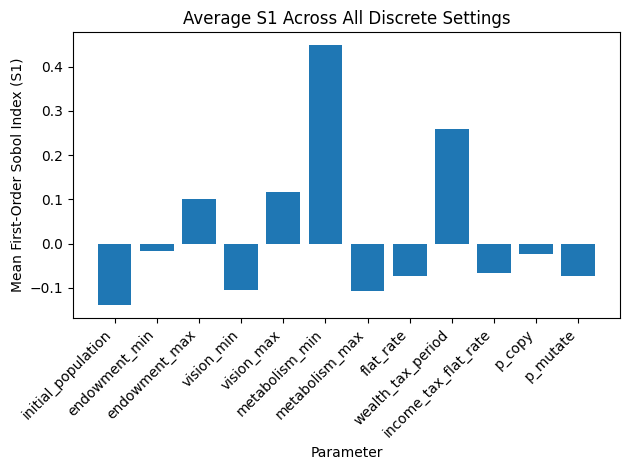

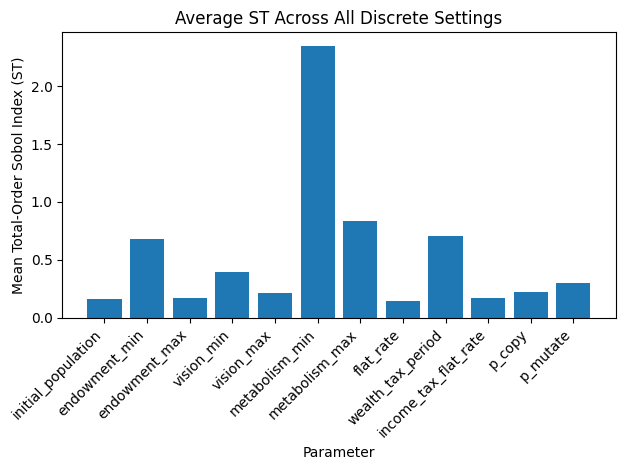

In [ ]:
# 1) Extract parameter names and build arrays
param_names = reduced_problem["names"]
S1_array = np.vstack([entry["S1"] for entry in sobol_summary])   # shape = (n_slices, n_params)
ST_array = np.vstack([entry["ST"] for entry in sobol_summary])   # same

# 2) Compute average indices across all discrete‐factor slices
mean_S1 = S1_array.mean(axis=0)
mean_ST = ST_array.mean(axis=0)

# 3) Pack into a DataFrame (optional, for reference)
df = pd.DataFrame({
    "Parameter": param_names,
    "Mean S1":   mean_S1,
    "Mean ST":   mean_ST
})

# 4a) Plot mean first‐order indices
plt.figure()
plt.bar(df["Parameter"], df["Mean S1"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Parameter")
plt.ylabel("Mean First‐Order Sobol Index (S1)")
plt.title("Average S1 Across All Discrete Settings")
plt.tight_layout()
plt.show()

# 4b) Plot mean total‐order indices
plt.figure()
plt.bar(df["Parameter"], df["Mean ST"])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Parameter")
plt.ylabel("Mean Total‐Order Sobol Index (ST)")
plt.title("Average ST Across All Discrete Settings")
plt.tight_layout()
plt.show()

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


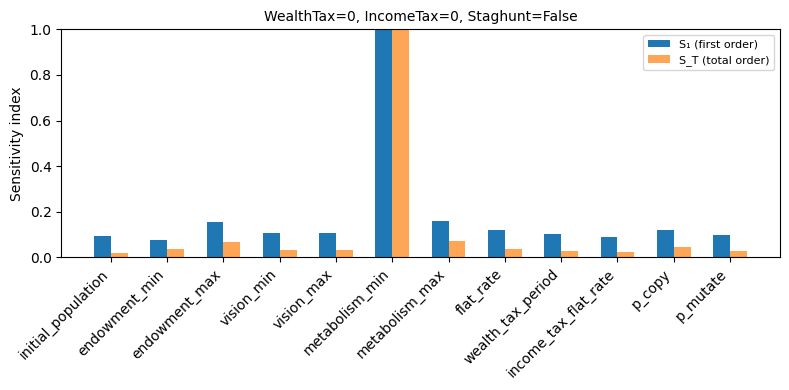

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


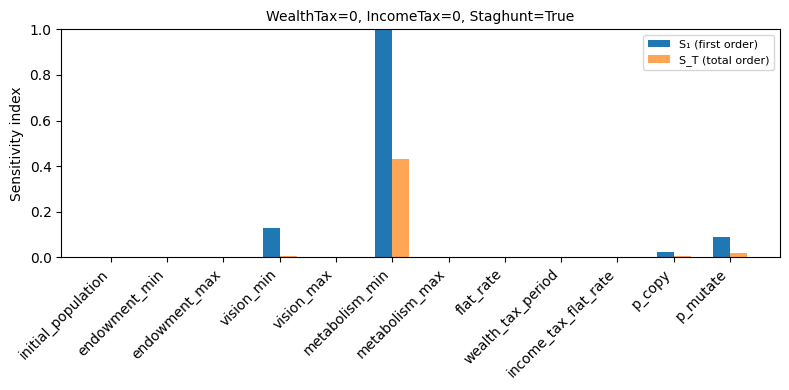

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


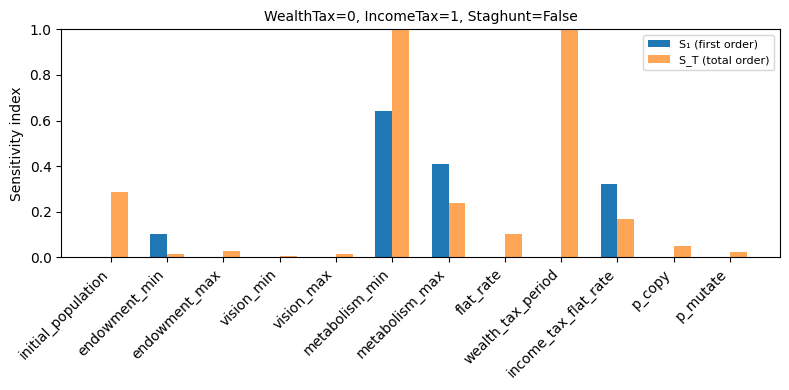

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


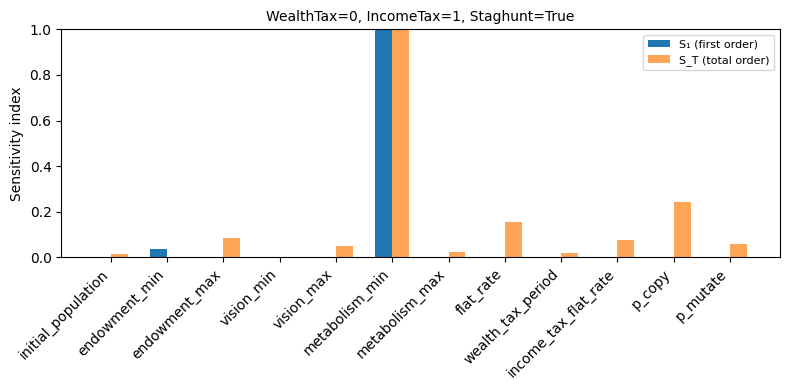

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


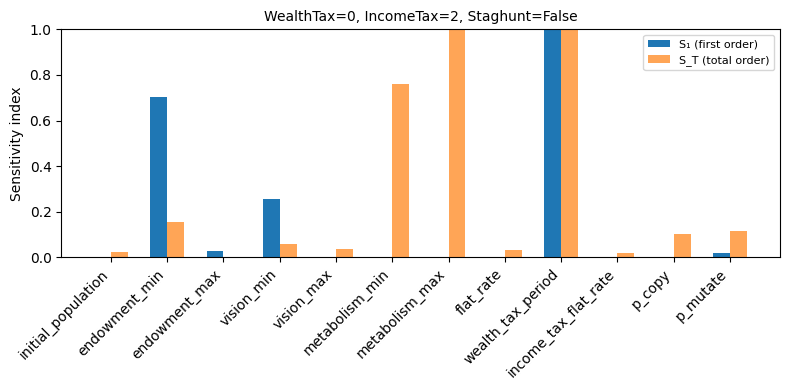

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


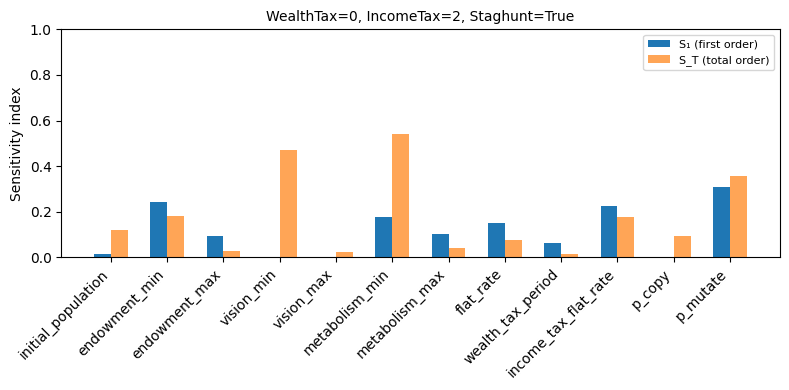

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


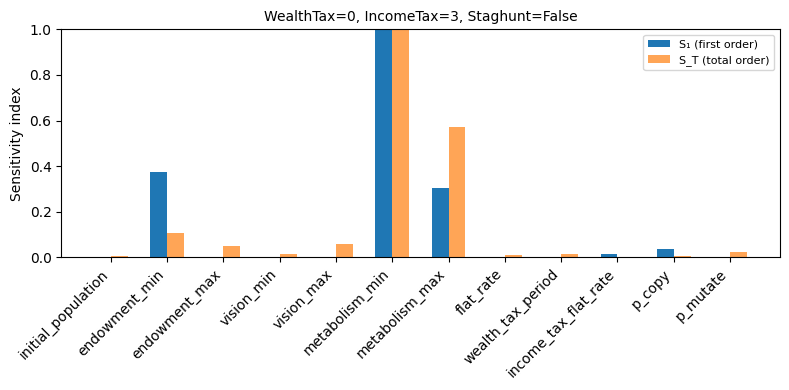

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


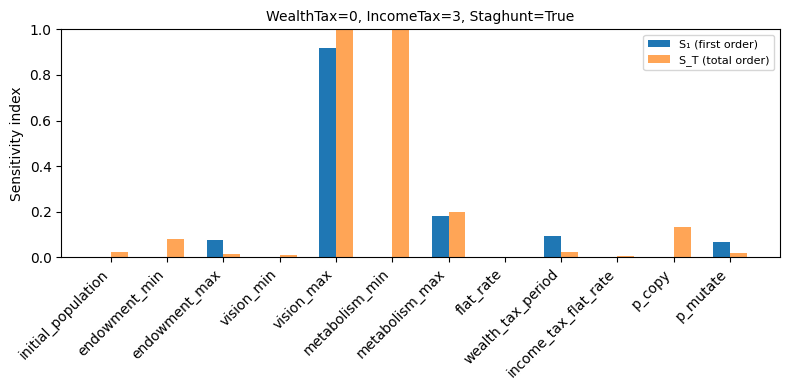

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


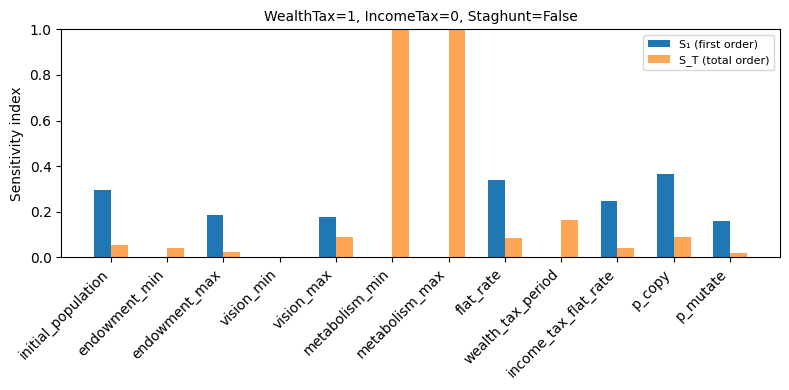

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


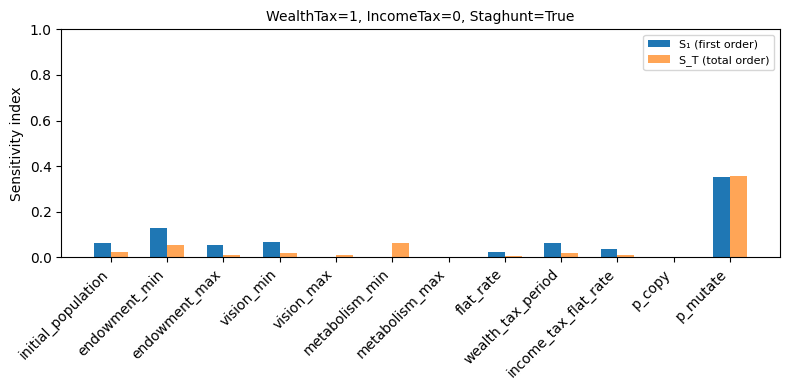

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


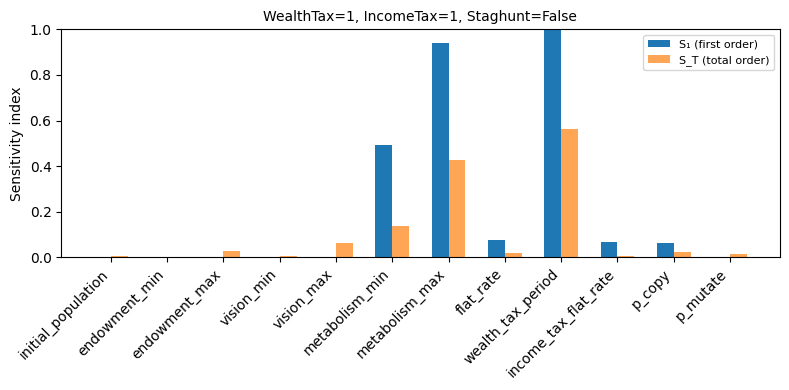

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


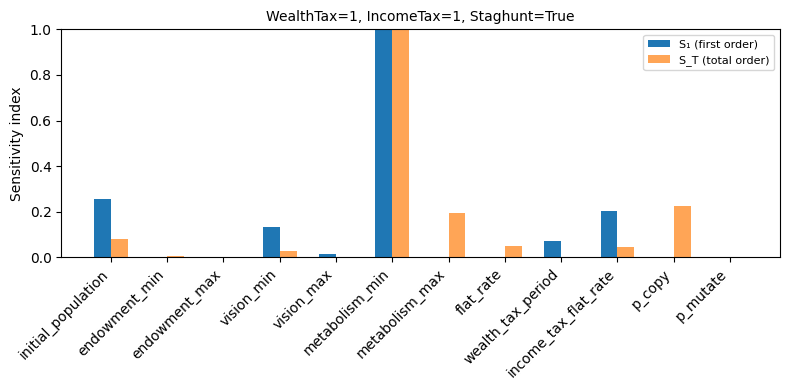

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


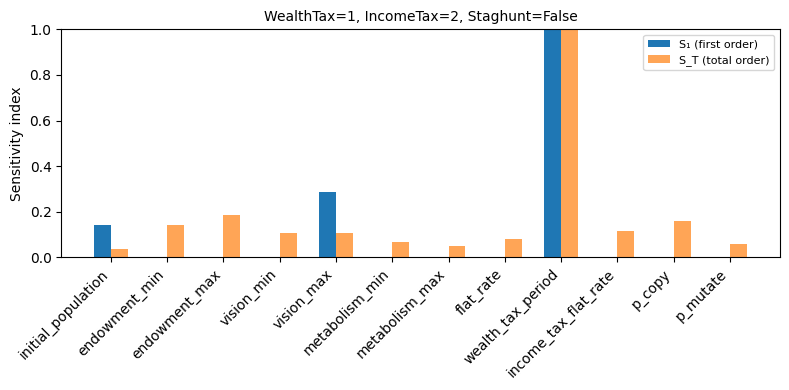

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


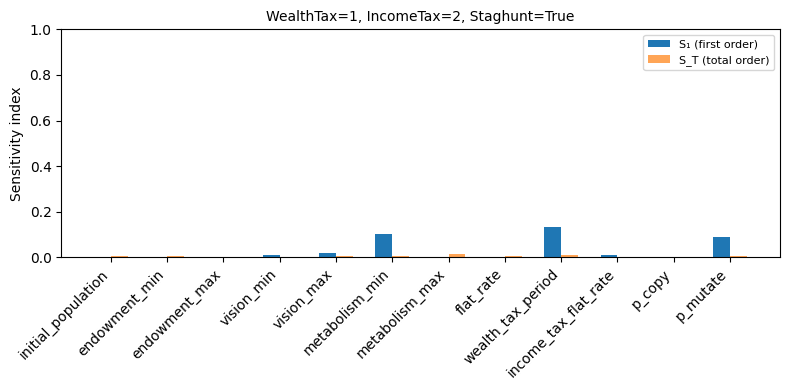

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


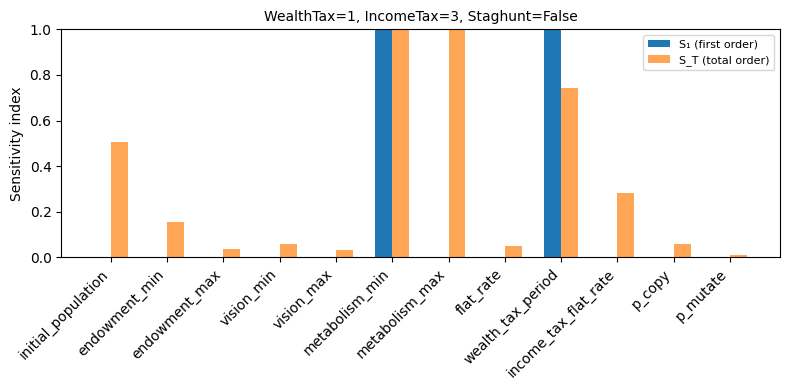

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


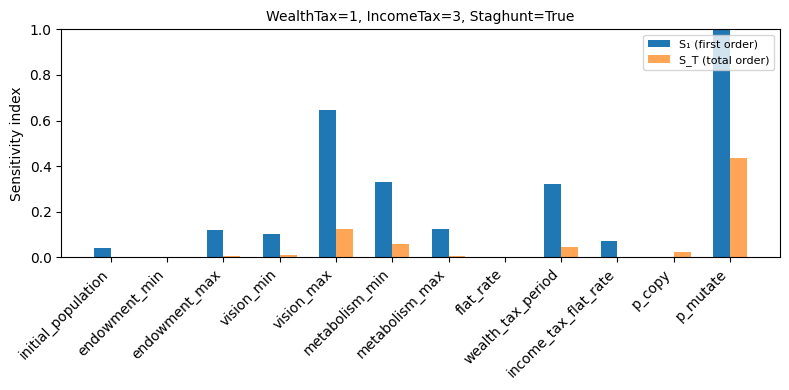

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


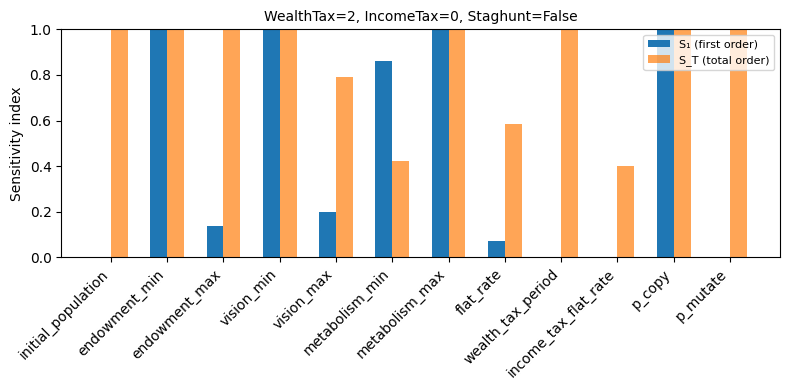

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


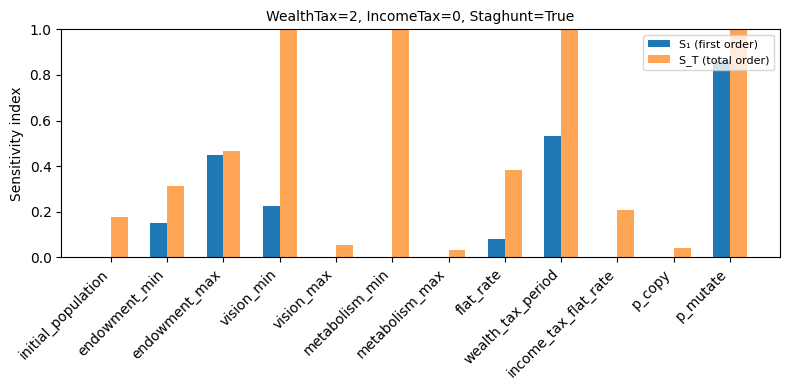

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


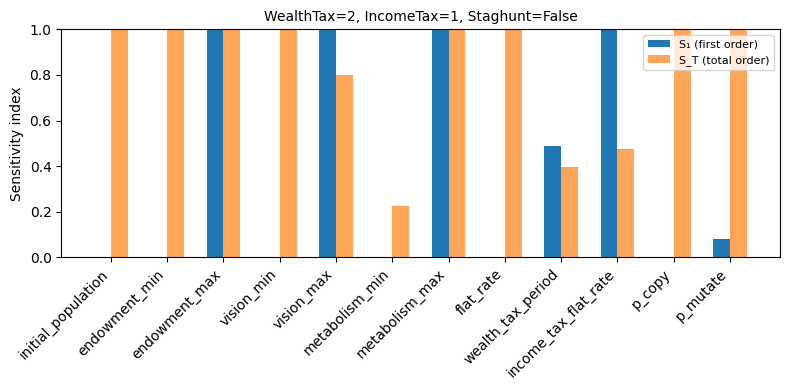

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


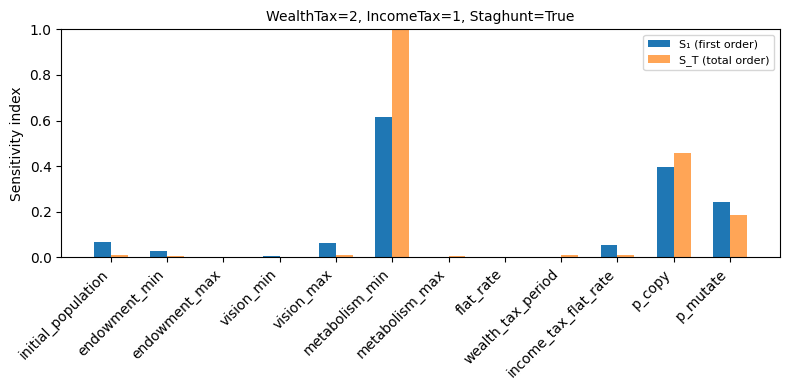

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


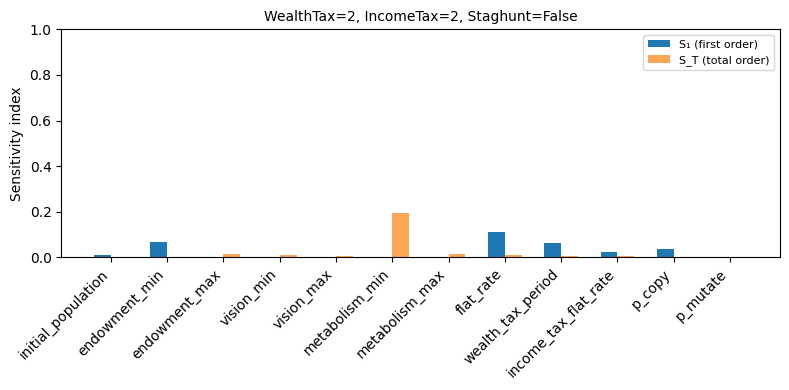

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


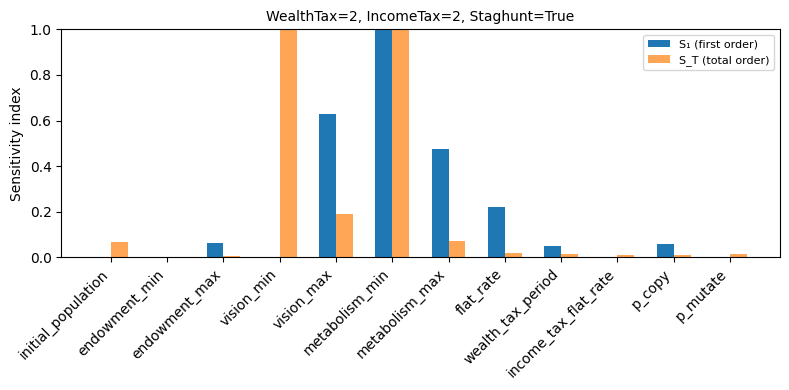

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


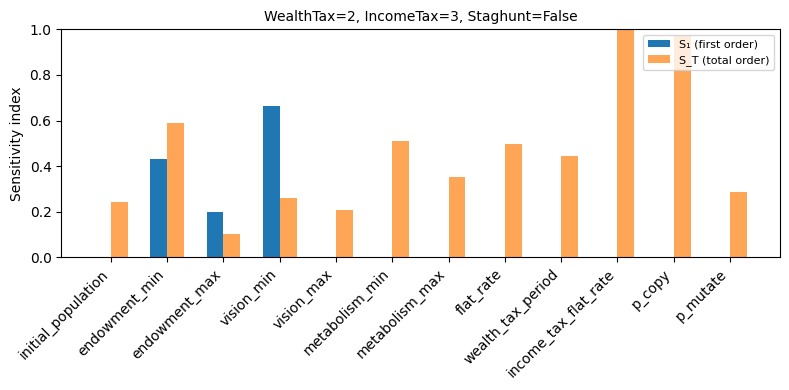

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


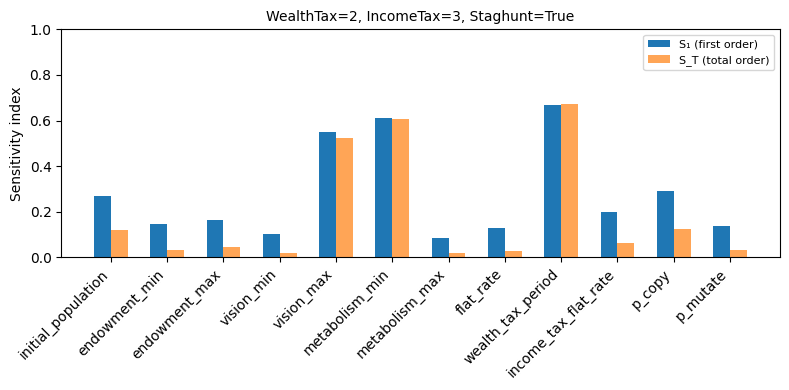

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


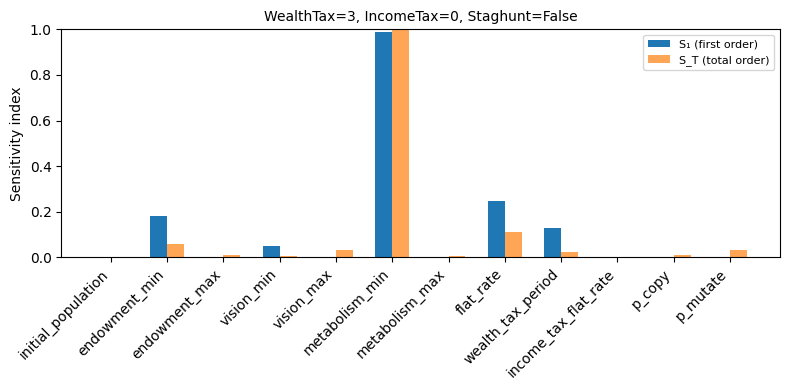

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


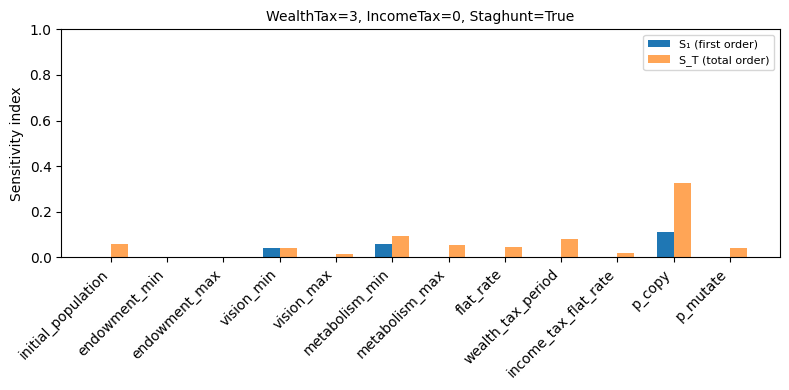

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


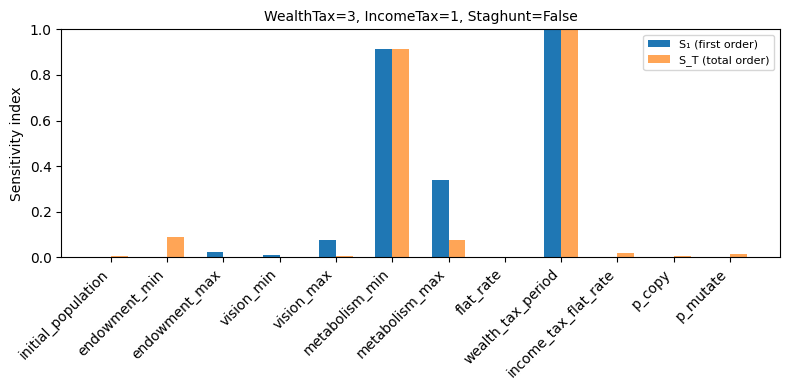

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


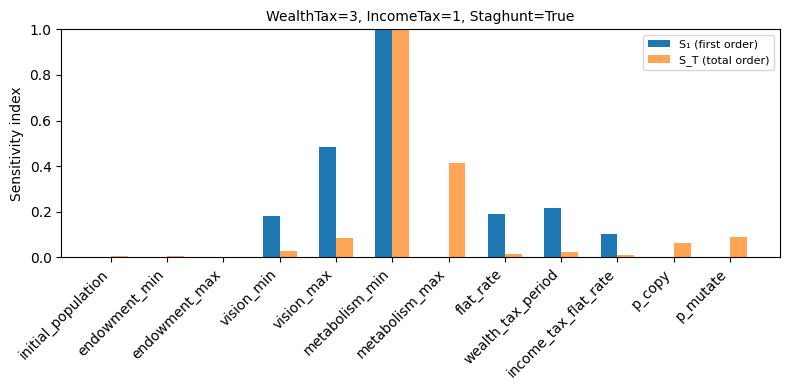

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


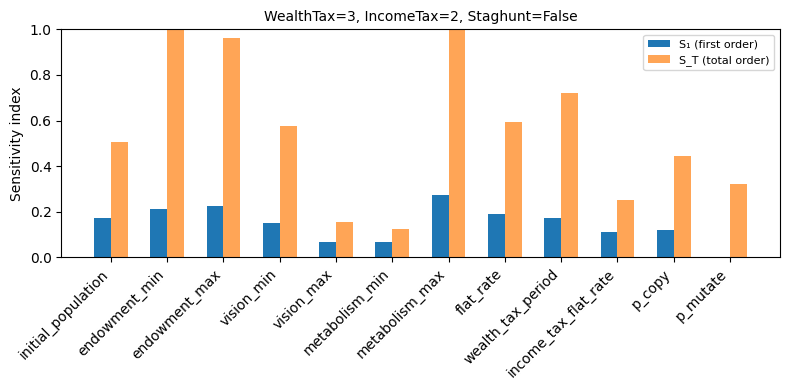

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


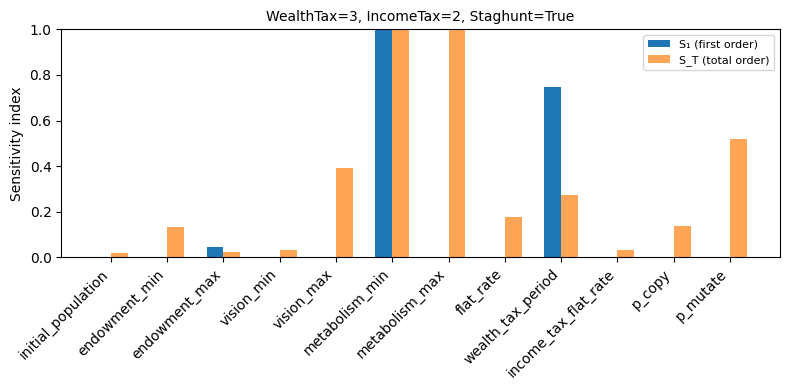

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


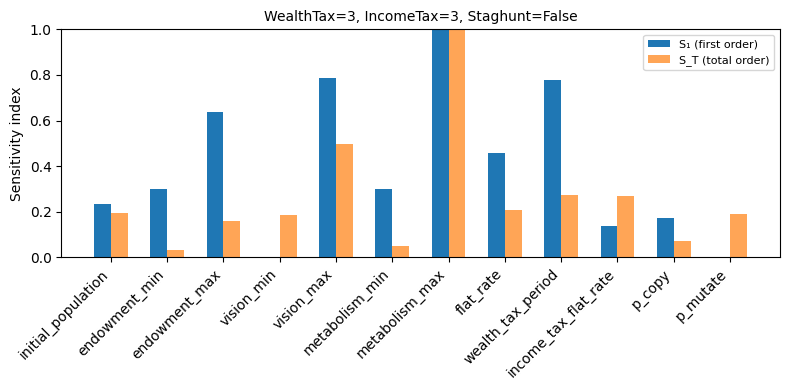

/Users/bartkoedijk/Bestanden/ABM/ABM/.venv/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


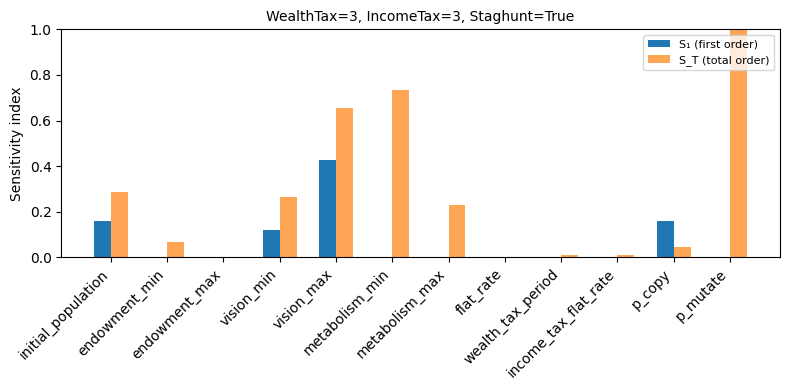

In [ ]:
with open("discrete_sobol_gsa_results.pkl", "rb") as f:
    all_records = pickle.load(f)

for rec in all_records:
    w_sys, i_sys, hunt_flag = rec["discrete_setting"]
    X = rec["samples"]       # the Sobol sample matrix for this slice
    Y = np.array([out[measure] for out in rec["results"]], dtype=float)
    # Run Sobol analysis (enable second-order if you sampled it)
    Si = sobol_analyze.analyze(
        reduced_problem,
        Y,
        calc_second_order=True,    # or False if you didn’t sample second order
        conf_level=0.95,
        print_to_console=False
    )

    # Extract first‐order and total‐order indices
    S1 = Si["S1"]
    ST = Si["ST"]

    # 4) Plot
    x = range(len(cont_vars))
    fig, ax = plt.subplots(figsize=(8, 4))

    ax.bar([i-0.15 for i in x], S1, width=0.3, label="S₁ (first order)")
    ax.bar([i+0.15 for i in x], ST, width=0.3, label="S_T (total order)", alpha=0.7)

    ax.set_xticks(x)
    ax.set_xticklabels(cont_vars, rotation=45, ha="right")
    ax.set_ylabel("Sensitivity index")
    ax.set_ylim(0, 1)
    ax.set_title(
        f"WealthTax={w_sys}, IncomeTax={i_sys}, Staghunt={bool(hunt_flag)}",
        fontsize=10
    )
    ax.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.show()